# A comparison between MALA and parallel tempering
--------
In this exercise, we will implement and compare the Metropolis Adjusted Langevin Monte Carlo(MALA) and parallel tempering for sampling from a double well potential $V(x) = 2(x^2 - 1)^2$.

-------

## Problem 1a
-----
Implement MALA to sample from $V(x)$, generating $10^5$ samples with a fixed step-size $\epsilon = 0.05$. Plot the trajectory of the samples.

-----

In [25]:
import numpy as np

def d_V(x):
    return 8*x**3 - 8*x

def run_mala_7_2_a(N, epsilon):
    X = np.zeros(N+1)  # Store all samples
    X[0] = 1  # Initial value
    num_rejected = 0  # Counter for rejected proposals

    for n in range(N):
        z = np.random.normal(X[n] - epsilon * d_V(X[n]), np.sqrt(2 * epsilon))  # Proposal
        u = np.random.uniform(0, 1)  # Uniform sample for Metropolis step
        log_u = np.log(u)
        # Compute density ratios for acceptance probability
        # log_pdf_z_f_over_pdf_x_f = np.log(np.exp(-beta*(z**4-z**2+0.25)) / np.exp(-beta*(X[n]**4 - X[n]**2 + 0.25)))
        
        log_pdf_z_f_over_pdf_x_f = 2*(X[n]**2 - 1)**2 - 2*(z**2 - 1)**2 
        
        log_q_xtoz = -((z - (X[n] - epsilon * d_V(X[n])))**2) / (4 * epsilon)
        log_q_ztox = -((X[n] - (z - epsilon * d_V(z)))**2) / (4 * epsilon)

        # Compute acceptance ratio
        a_x_z = min(0, log_pdf_z_f_over_pdf_x_f + log_q_ztox- log_q_xtoz)

        # Accept or reject
        if log_u <= a_x_z:
            X[n+1] = z
        else:
            X[n+1] = X[n]

    return X


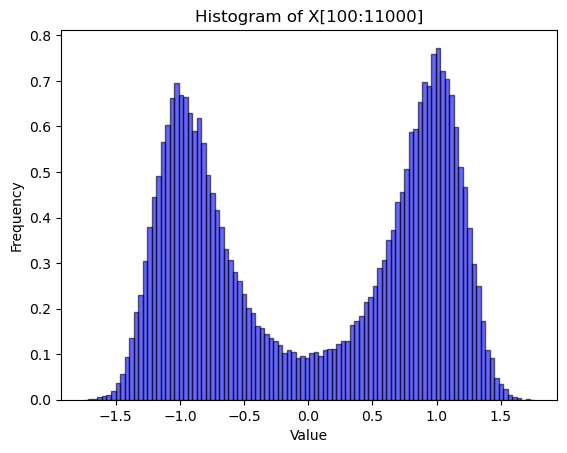

In [27]:
import matplotlib.pyplot as plt
X = run_mala_7_2_a(100000,0.05)

plt.hist(X, bins=100, density=True, alpha=0.6, color='b', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of X[100:11000]')

# Show the plot
plt.show()


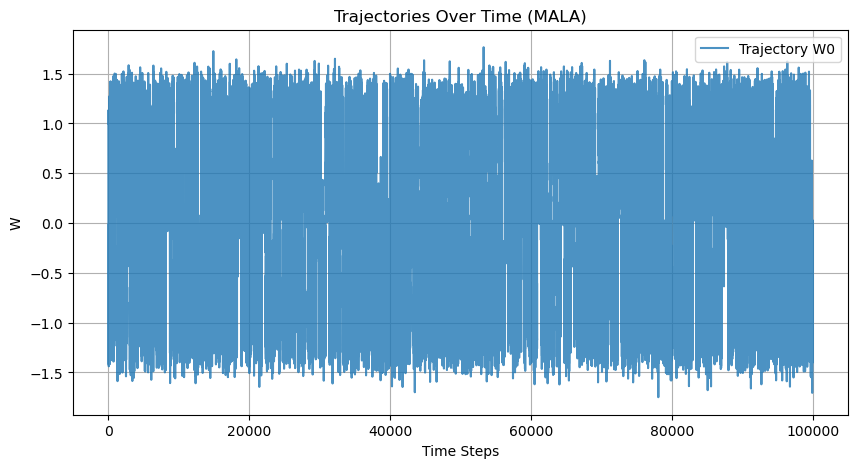

In [29]:
# Define time steps
num_steps = X.shape[0]
time = np.arange(num_steps)  # Time axis

# Plot each column as a trajectory
plt.figure(figsize=(10, 5))
plt.plot(time, X, label="Trajectory W0", alpha=0.8)

# Formatting the plot
plt.xlabel('Time Steps')
plt.ylabel('W')
plt.title('Trajectories Over Time (MALA)')
plt.legend()
plt.grid(True)
plt.show()

## Problem 1b

---
Implement parallel tempering using 4 chains at temperatures 1, 1/2, 1/4, 1/8 with a fixed step-size $\epsilon = 0.05$, generating $10^5$ samples per chain. After every 10 samples, randomly select two chains and attempt a swap using the Metropolis criterion. Plot the trajectories for all chains.

---

In [32]:
# Set parameters
num_samples = 100000 # 10^5 samples
epsilon = 0.05  # Step size
temperatures = [1, 1/2, 1/4, 1/8]  # Temperatures for the chains
chains = np.zeros((4,100001))
chains[:,0] = [np.random.normal() for i in range(4)]
# Parallel tempering implementation
import numpy as np
import matplotlib.pyplot as plt

# Define the potential function V(x)
def V(x,temp):
    return 2 * (x**2 - 1)**2 * temp
# Define the gradient of the potential for Metropolis Adjusted Langevin Algorithm (MALA)
def grad_V(x,temp):
    return 8 * x * (x**2 - 1) * temp

# Metropolis update function for sampling
def metropolis(x_current, x_proposed, V_current, V_proposed, epsilon, temp):
    log_u =np.log(np.random.uniform())
    
    log_fz_fx = -V_proposed + V_current
    
    log_q_xtoz = -((x_proposed - (x_current - epsilon * grad_V(x_current, temp)))**2) / (4 * epsilon / temp)
    log_q_ztox = -((x_current - (x_proposed - epsilon * grad_V(x_proposed,temp)))**2) / (4 * epsilon / temp)

    log_acceptance_prob = min(0, log_fz_fx + log_q_ztox- log_q_xtoz)
    
    if log_u < log_acceptance_prob:
        return x_proposed
    return x_current

def parallel_tempering(num_samples, epsilon, temperatures):

    # Perform parallel tempering sampling
    for step in range(num_samples):
        for i, T in enumerate(temperatures):

            
            x_current = chains[i,step]
            grad = grad_V(x_current, T)
            
            # Propose new state using Langevin dynamics (Euler step)
            x_proposed = np.random.normal(x_current - epsilon * grad, np.sqrt(2 * epsilon / T))  # Proposal
            
            V_current = V(x_current,T) 
            V_proposed = V(x_proposed,T) 
            
            # Metropolis update
            chains[i,step+1] = metropolis(x_current, x_proposed, V_current, V_proposed, epsilon, T)

        # Attempt swaps between adjacent chains every 10 samples
        if (step+1) % 10 == 0:
            i,j = np.random.choice(range(4), size=2, replace=False)  # Randomly select two adjacent chains
            
            chain_i = chains[i,step+1]
            chain_j = chains[j,step+1]
            
            v_betai_xj = V(chain_j,temperatures[i]) 
            v_betaj_xi = V(chain_i,temperatures[j]) 
            v_betai_xi = V(chain_i,temperatures[i])
            v_betaj_xj = V(chain_j,temperatures[j])
            
            #V_i = V(chain_i)
            #V_j = V(chain_j)
            
            # Swap proposal using Metropolis criterion
            log_acceptance_prob = min(0, -v_betai_xj - v_betaj_xi + v_betai_xi + v_betaj_xj)
            
            if np.log(np.random.rand()) < log_acceptance_prob:
                
                chains[i, step +1], chains[j, step + 1] = chain_j, chain_i
    
    return chains




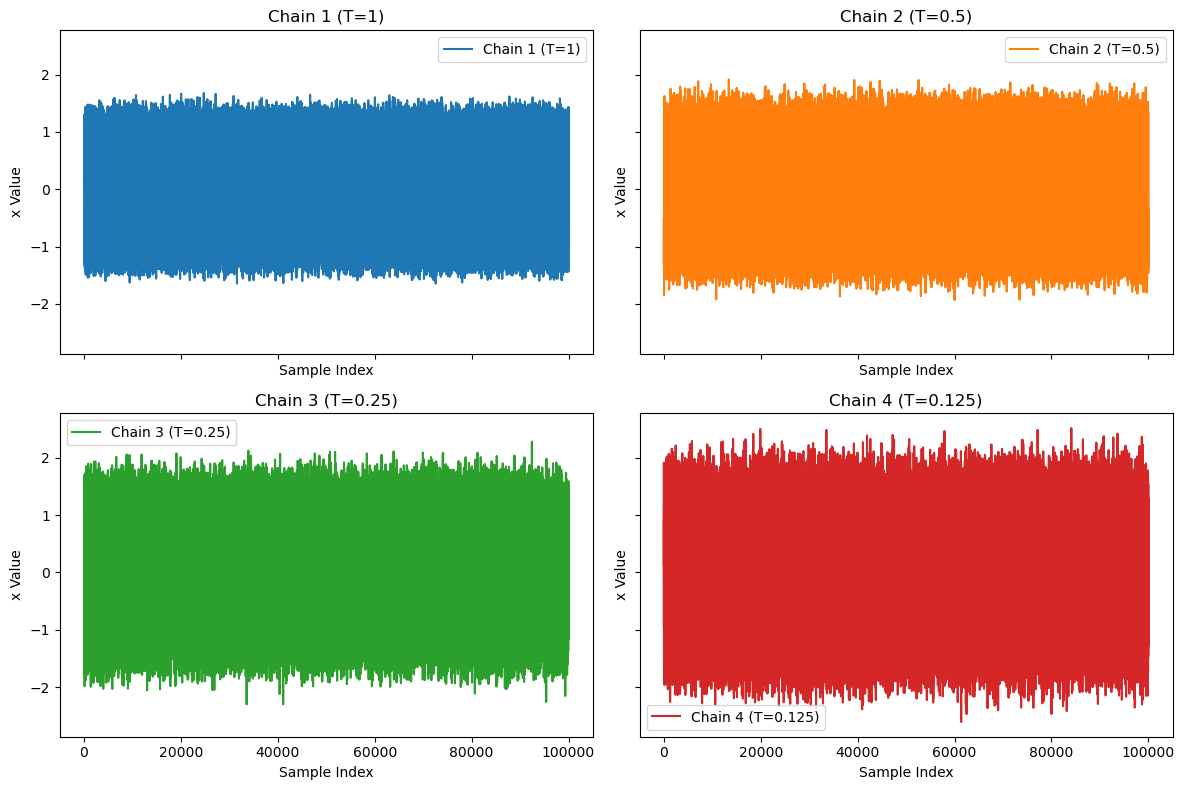

In [34]:
# Run parallel tempering
samples = parallel_tempering(num_samples, epsilon, temperatures)

# Create a 2x2 subplot grid for separate plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# Flatten axes array for easier indexing if needed
axes = axes.flatten()

# Plot each chain separately
for i, sample in enumerate(samples):
    axes[i].plot(sample, label=f"Chain {i+1} (T={temperatures[i]})", color=f'C{i}')
    axes[i].set_title(f"Chain {i+1} (T={temperatures[i]})")
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel("x Value")
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

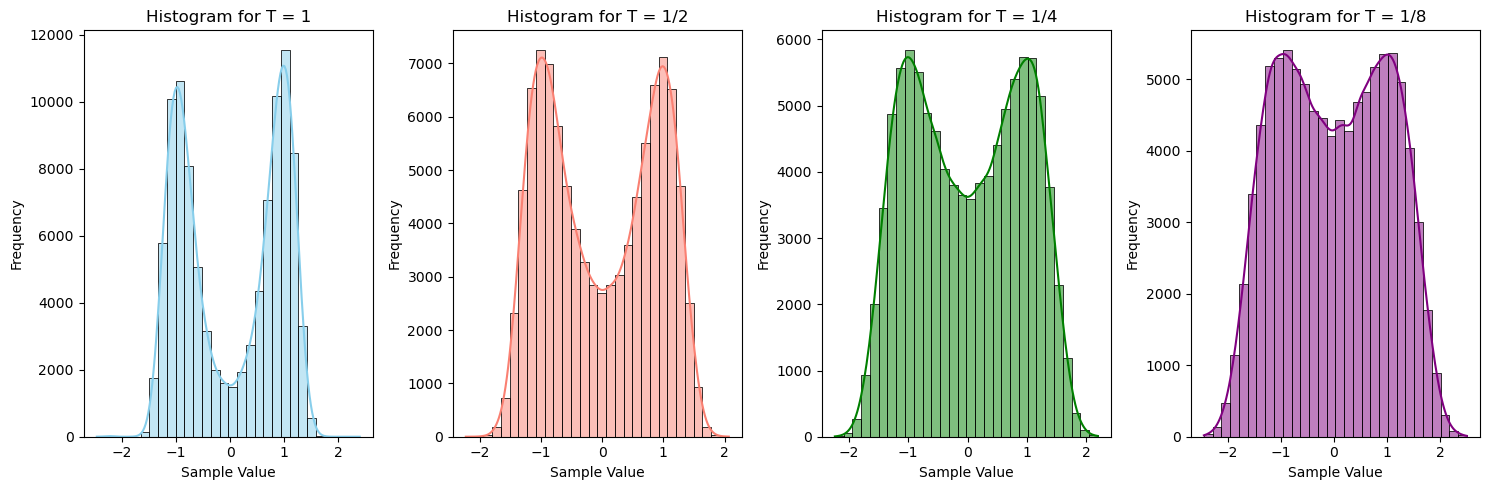

In [40]:
import seaborn as sns  # Need to import seaborn
import matplotlib.pyplot as plt

# Create a 1x4 subplot (since you have 4 temperatures)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Changed from 1x3 to 1x4

# Plot histogram for T = 1 (Chain 0)
sns.histplot(samples[0,:], kde=True, bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Histogram for T = 1')
axes[0].set_xlabel('Sample Value')
axes[0].set_ylabel('Frequency')

# Plot histogram for T = 1/2 (Chain 1)
sns.histplot(samples[1,:], kde=True, bins=30, ax=axes[1], color='salmon')
axes[1].set_title('Histogram for T = 1/2')  # Fixed title (was 'c = 1/2')
axes[1].set_xlabel('Sample Value')
axes[1].set_ylabel('Frequency')

# Plot histogram for T = 1/4 (Chain 2)
sns.histplot(samples[2,:], kde=True, bins=30, ax=axes[2], color='green')
axes[2].set_title('Histogram for T = 1/4')  # Fixed title (was 'c = 1/4')
axes[2].set_xlabel('Sample Value')
axes[2].set_ylabel('Frequency')

# Plot histogram for T = 1/8 (Chain 3)
sns.histplot(samples[3,:], kde=True, bins=30, ax=axes[3], color='purple')  # Changed color to distinguish
axes[3].set_title('Histogram for T = 1/8')  # Fixed title and index (was using axes[2])
axes[3].set_xlabel('Sample Value')          # Fixed index from 2 to 3
axes[3].set_ylabel('Frequency')            # Fixed index from 2 to 3

# Adjust layout
plt.tight_layout()
plt.show()

## Problem 2a

----
For MALA, perform 10 runs to sample from $V(x)$, recording the number of steps required for transitions fromrequency $x < 0$ to $x > 0$ and vice versa up to $10^5$ samples. Assume the starting position is randomly chosen from the standard normal distribution. Compute the average transition steps over the runs.

----

In [36]:
MC_output = np.zeros((10,100001))
for i in range(10):
    MC_output[i,:] = run_mala_7_2_a(100000,0.05)

In [38]:
import numpy as np

def find_sign_changes(lst):
    change_positions = []
    
    for i in range(1, len(lst)):
        if (lst[i-1] < 0 and lst[i] >= 0) or (lst[i-1] >= 0 and lst[i] < 0):
            change_positions.append(i)
    
    return change_positions

# Create the matrix with 10 rows
matrix = []

# Fill the matrix with the sign change positions
for i in range(10):
    matrix.append(find_sign_changes(MC_output[i,:]))


In [40]:
differences = [np.diff(row) for row in matrix]

In [44]:
avg_diff = [np.mean(differences[i]) for i in range(10)]

In [46]:
avg_diff

[46.70632318501171,
 48.69444444444444,
 48.32009685230024,
 45.46420428636571,
 46.30855018587361,
 47.02164705882353,
 47.06462264150943,
 47.90743405275779,
 46.021178637200734,
 48.17012048192771]

In [48]:
np.mean(avg_diff) #the average transition step for MALA is 47.142

47.16786218262149

## Problem 2b
-----
For Parallel tempering, perform 10 runs to sample from $V(x)$, recording the number of steps required for transitions fromrequency $x < 0$ to $x > 0$ and vice versa up to $10^5$ samples. Assume the starting position is randomly chosen from the standard normal distribution. Compute the average transition steps over the runs.

-----

In [50]:
# Run parallel tempering
MC_output_para = np.zeros((40,100001))
for i in range(10):
    MC_output_para[4*i:4*(i+1),:] = parallel_tempering(num_samples, epsilon, temperatures)

# Create the matrix with 10 rows
matrix = []

# Fill the matrix with the sign change positions
for i in range(40):
    matrix.append(find_sign_changes(MC_output_para[i,:]))


In [52]:
differences = [np.diff(row) for row in matrix]
avg_diff = [np.mean(differences[i]) for i in range(40)]


In [54]:
avg_transition_step_T1 = [avg_diff[4*i] for i in range(10)]
avg_transition_step_T2 = [avg_diff[4*i+1] for i in range(10)]
avg_transition_step_T3 = [avg_diff[4*i+2] for i in range(10)]
avg_transition_step_T4 = [avg_diff[4*i+3] for i in range(10)]

# Calculating and printing the mean of each list
mean_T1 = sum(avg_transition_step_T1) / len(avg_transition_step_T1)
mean_T2 = sum(avg_transition_step_T2) / len(avg_transition_step_T2)
mean_T3 = sum(avg_transition_step_T3) / len(avg_transition_step_T3)
mean_T4 = sum(avg_transition_step_T4) / len(avg_transition_step_T4)

# Print the means
print(f"Mean of avg_transition_step_T1: {mean_T1}")
print(f"Mean of avg_transition_step_T2: {mean_T2}")
print(f"Mean of avg_transition_step_T3: {mean_T3}")
print(f"Mean of avg_transition_step_T4: {mean_T4}")


Mean of avg_transition_step_T1: 26.4979353821118
Mean of avg_transition_step_T2: 12.133602939999502
Mean of avg_transition_step_T3: 7.154904887753718
Mean of avg_transition_step_T4: 5.158144905705116


## Problem 2c 
---
Compare the average transition times for MALA and parallel tempering, discussing the efficiency and computational cost of each method.


---

---
The average transition time for MALA is 47.142, the average transition time for parallel tempering for T = 1, 1/2, 1/4, 1/8 are 26.57, 12.12, 7.19, 5.16. It is obvious that parallel tempering is more efficient than MALA interms of transition time. And as temperature increase, the transition time decrease since it is easier to move from one peak to another peak. However, parallel tempering is more computional demanding as it has a much longer running time

---